# EDA and split for ProtCID data

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DATA_DIR = '/home/ec2-user/SageMaker/efs/data/ProtCID/JaredJanssen_Benchmark'

In [3]:
!ls -l {DATA_DIR}

total 30372
drwxrwxr-x 4 ec2-user ec2-user     6144 Oct 14 15:06 camp_preprocess_test
drwxrwxr-x 4 ec2-user ec2-user     6144 Oct  6 19:03 camp_preprocess_train
-rwxrwx--- 1 ec2-user ec2-user     2078 Sep 17 22:58 HeaderAnnotations.txt
drwxrwx--- 3 ec2-user ec2-user     6144 Sep 18 02:22 non-physiol
drwxrwx--- 3 ec2-user ec2-user     6144 Sep 18 02:31 physiol
-rwxrwx--- 1 ec2-user ec2-user    16600 Sep 18 02:05 ProcedureBenchmarkDimers.docx
-rw-rw-r-- 1 ec2-user ec2-user 13473246 Sep 23 18:52 ProtCID_proteins.fasta
-rw-rw-r-- 1 ec2-user ec2-user  3161922 Oct 27 13:50 test_full.csv
-rw-rw-r-- 1 ec2-user ec2-user   321027 Nov  4 01:51 test_small.csv
-rwxrwxr-x 1 ec2-user ec2-user     2022 Sep 18 02:41 TextFileNameStructure.txt
-rw-rw-r-- 1 ec2-user ec2-user 12830792 Oct 27 13:50 train_full.csv
-rw-rw-r-- 1 ec2-user ec2-user  1258012 Nov  4 01:51 train_small.csv


In [4]:
# !ls -l {DATA_DIR}/non-physiol

In [5]:
# !wc -l {DATA_DIR}/non-physiol/*.txt

In [6]:
# !head {DATA_DIR}/non-physiol/homoNonPhysiolDimerList_unpPdbCF5_all.txt

In [7]:
# !ls -lh {DATA_DIR}/non-physiol/non-physiol_pdb/homo | head

In [8]:
# !ls -l {DATA_DIR}/non-physiol/non-physiol_pdb/homo | wc -l

In [9]:
# !ls -l {DATA_DIR}/physiol/physiol_pdb/homo | wc -l

In [10]:
# !ls -l {DATA_DIR}/non-physiol/non-physiol_pdb/hetero | wc -l

In [11]:
# !ls -l {DATA_DIR}/physiol/physiol_pdb/hetero | wc -l

In [12]:
pd.set_option('display.max_columns', None)

## Collect pdb file paths

In [13]:
meta_df = []
for label in ['physiol', 'non-physiol']:
    for complex_type in ['homo', 'hetero']:
        relative_path = f'{label}/{label}_pdb/{complex_type}'
        for pdb_file in os.listdir(os.path.join(DATA_DIR, relative_path)):
            relative_path_to_pdb_file = os.path.join(relative_path, pdb_file)
            
            file_str = pdb_file.split('.')[0]
            
            row = {
                'id': file_str,
                'label': label, 
                'complex_type': complex_type, 
                'pdb_file': relative_path_to_pdb_file,
                'UnpID': '_'.join(file_str.split('_')[0:-2]),
                'PdbID': file_str.split('_')[-2],
                'InterfaceID': int(file_str.split('_')[-1]),
            }
            meta_df.append(row)
            
meta_df = pd.DataFrame(meta_df).set_index('id', verify_integrity=True)
meta_df.shape

(21446, 6)

In [14]:
meta_df.tail()

,label,complex_type,pdb_file,UnpID,PdbID,InterfaceID
id,,,,,,
IL2_HUMAN-IL2RB_HUMAN_5m5e_3,non-physiol,hetero,non-physiol/non-physiol_pdb/hetero/IL2_HUMAN-I...,IL2_HUMAN-IL2RB_HUMAN,5m5e,3
COX1_BOVIN-COX41_BOVIN_5b1b_3,non-physiol,hetero,non-physiol/non-physiol_pdb/hetero/COX1_BOVIN-...,COX1_BOVIN-COX41_BOVIN,5b1b,3
B2MG_CHICK-Q9GIP6_CHICK_6kx9_5,non-physiol,hetero,non-physiol/non-physiol_pdb/hetero/B2MG_CHICK-...,B2MG_CHICK-Q9GIP6_CHICK,6kx9,5
H2A1B_HUMAN-H2B1K_HUMAN_6l9h_8,non-physiol,hetero,non-physiol/non-physiol_pdb/hetero/H2A1B_HUMAN...,H2A1B_HUMAN-H2B1K_HUMAN,6l9h,8
NIFD_CLOPA-NIFK_CLOPA_4wes_9,non-physiol,hetero,non-physiol/non-physiol_pdb/hetero/NIFD_CLOPA-...,NIFD_CLOPA-NIFK_CLOPA,4wes,9


In [15]:
meta_df.groupby(['label', 'complex_type']).size()

label        complex_type
non-physiol  hetero           551
             homo            4925
physiol      hetero          6854
             homo            9116
dtype: int64

In [16]:
meta_df['InterfaceID'].value_counts()

1      3886
2      2201
3      1942
4      1672
5      1450
       ... 
262       1
385       1
233       1
399       1
392       1
Name: InterfaceID, Length: 292, dtype: int64

## Parse protein sequences from PDB files

In [17]:
from ppi.data_utils import gunzip_to_ram, three_to_one_standard
from ppi.data_utils import parse_pdb_structure

In [18]:
from Bio.PDB import MMCIFParser, PDBParser
from Bio.PDB.Polypeptide import three_to_one, is_aa

def get_chain_sequences(structure):
    result = {}
    ligands = []
    for chain in structure.get_chains():
        seq = "".join(
            [
                three_to_one_standard(res.get_resname())
                for res in chain.get_residues()
                if is_aa(res)
            ]
        )
        for res in chain.get_residues():
            if not is_aa(res) and res.id[0] != 'W':
                ligands.append(res.get_resname())
        result[structure.id + '-' + chain.id] = seq
    return result, ligands

In [19]:
from tqdm import tqdm
all_seqs = {}
all_ligands = []
rows_with_errors = []

pdb_parser = PDBParser(
    QUIET=True,
    PERMISSIVE=True,
)

In [ ]:
for i in tqdm(range(meta_df.shape[0])):
    row = meta_df.iloc[i]
    try:
        structure = parse_pdb_structure(
            pdb_parser,
            row.name, 
            os.path.join(DATA_DIR, row['pdb_file'])  
        )    
    except:
        rows_with_errors.append(row.name)
        pass
    else:
        seqs, ligands = get_chain_sequences(structure)
        all_seqs.update(seqs)
        all_ligands.append(ligands)

In [36]:
print('number of chains:', len(all_seqs))
print('number of unique sequences:', len(set(all_seqs.values())))

number of chains: 42876
number of unique sequences: 21160


In [35]:
print('number of PDB files with parsing errors:', len(rows_with_errors))

number of PDB files with parsing errors: 8


In [37]:
# write a fasta file for all ProtCID protein sequences
with open(os.path.join(DATA_DIR, 'ProtCID_proteins.fasta'), 'w') as out:
    for pdb_chain_id, seq in all_seqs.items():
        out.write('>' + pdb_chain_id + '\n')
        out.write(seq + '\n')

## Load protein sequences from the fasta file

In [20]:
from Bio import SeqIO

In [21]:
fasta = SeqIO.parse(os.path.join(DATA_DIR, 'ProtCID_proteins.fasta'), "fasta")
seqs = []
for item in fasta:
    seq = str(item.seq)
    if seq != '':
        seqs.append({'seq': seq, 'id': item.id})

# len(cluster_seqs)
seqs = pd.DataFrame(seqs).set_index('id', verify_integrity=True)
print(seqs.nunique())
seqs.head()

seq    21160
dtype: int64


,seq
id,
CAPP1_MAIZE_6u2t_4-A,KHHSIDAQLRQLVPGKVSEDDKLIEYDALLVDRFLNILQDLHGPSL...
CAPP1_MAIZE_6u2t_4-B,KHHSIDAQLRQLVPGKVSEDDKLIEYDALLVDRFLNILQDLHGPSL...
Q31135_MOUSE_6blr_3-A,LVERLYLVCGEEGAGGGSLVGERHFVHQFKGECYFTNGTQRIRLVT...
Q31135_MOUSE_6blr_3-B,LVERLYLVCGEEGAGGGSLVGERHFVHQFKGECYFTNGTQRIRLVT...
DPOLL_HUMAN_5iio_6-A,NHNLHITEKLEVLAKAYSVQGDKWRALGYAKAINALKSFHKPVTSY...


In [22]:
seqs.shape

(42876, 1)

In [23]:
seqs['chain_id'] = seqs.index.map(lambda x: x.split('-')[-1])
seqs['structure_id'] = seqs.index.map(lambda x: '-'.join(x.split('-')[0:-1]))
print(seqs['structure_id'].nunique())
seqs['chain_id'].value_counts()

21438


A    21438
B    21438
Name: chain_id, dtype: int64

## Load sequence clustering results

In [24]:
seq_clusters_df = pd.read_csv(
    '/home/ec2-user/SageMaker/efs/results/sequence_clustering/combined_datasets_newprotcid_0.6Cov0_cluster.tsv',
    sep='\t',
    names=['cluster_center', 'member']
)
print(seq_clusters_df.shape)
print(seq_clusters_df.nunique())

(73130, 2)
cluster_center     9787
member            73130
dtype: int64


In [25]:
seq_clusters_df = seq_clusters_df.set_index('member')

In [26]:
seq_clusters_df.head()

,cluster_center
member,
NADA_PYRHO_5kts_5-A,NADA_PYRHO_5kts_5-A
NADA_PYRHO_6or8_7-A,NADA_PYRHO_5kts_5-A
NADA_PYRHO_6or8_7-B,NADA_PYRHO_5kts_5-A
NADA_PYRHO_5kts_5-B,NADA_PYRHO_5kts_5-A
NADA_PYRHO_4zk6_1-A,NADA_PYRHO_5kts_5-A


In [27]:
# join with `seqs`
seqs = seqs.merge(
    seq_clusters_df,
    how='left',
    left_index=True, 
    right_index=True
)
print(seqs.shape)
seqs.head()

(42876, 4)


,seq,chain_id,structure_id,cluster_center
id,,,,
CAPP1_MAIZE_6u2t_4-A,KHHSIDAQLRQLVPGKVSEDDKLIEYDALLVDRFLNILQDLHGPSL...,A,CAPP1_MAIZE_6u2t_4,CAPP1_MAIZE_6mgi_4-A
CAPP1_MAIZE_6u2t_4-B,KHHSIDAQLRQLVPGKVSEDDKLIEYDALLVDRFLNILQDLHGPSL...,B,CAPP1_MAIZE_6u2t_4,CAPP1_MAIZE_6mgi_4-A
Q31135_MOUSE_6blr_3-A,LVERLYLVCGEEGAGGGSLVGERHFVHQFKGECYFTNGTQRIRLVT...,A,Q31135_MOUSE_6blr_3,6u3m-E-B|MHC
Q31135_MOUSE_6blr_3-B,LVERLYLVCGEEGAGGGSLVGERHFVHQFKGECYFTNGTQRIRLVT...,B,Q31135_MOUSE_6blr_3,6u3m-E-B|MHC
DPOLL_HUMAN_5iio_6-A,NHNLHITEKLEVLAKAYSVQGDKWRALGYAKAINALKSFHKPVTSY...,A,DPOLL_HUMAN_5iio_6,DPOLL_HUMAN_5iio_3-A


In [28]:
seqs = seqs.groupby(['structure_id', 'chain_id'])['seq', 'cluster_center'].first().unstack()
print(seqs.shape)
seqs.head() # pdb files x sequences of chains

(21438, 4)


/tmp/ipykernel_29900/2774498782.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  seqs = seqs.groupby(['structure_id', 'chain_id'])['seq', 'cluster_center'].first().unstack()


seq  \
chain_id                                                             A   
structure_id                                                             
1433B_HUMAN_5n10_1   MDKSELVQKAKLAEQAERYDDMAAAMKAVTEQGHELSNEERNLLSV...   
1433B_HUMAN_6hep_8   MGSMTMDKSELVQKAKLAEQAERYDDMAAAMKAVTEQGHELSNEER...   
1433C_TOBAC_2o98_16  AVAPTAREENVYMAKLAEQAERYEEMVEFMEKVSNSLGSEELTVEE...   
1433C_TOBAC_3m50_2   EENVYMAKLAEQAERYEEMVEFMEKVSNSLEELTVEERNLLSVAYK...   
1433C_TOBAC_5nwj_1   APTAREENVYMAKLAEQAERYEEMVEFMEKVSNSLGSEELTVEERN...   

                                                                        \
chain_id                                                             B   
structure_id                                                             
1433B_HUMAN_5n10_1   QGSMTMDKSELVQKAKLAEQAERYDDMAAAMKAVTEQGHELSNEER...   
1433B_HUMAN_6hep_8   MDKSELVQKAKLAEQAERYDDMAAAMKAVTEQGHELSNEERNLLSV...   
1433C_TOBAC_2o98_16  AVAPTAREENVYMAKLAEQAERYEEMVEFMEKVSNSLGSEELTVEE...   
1433C_TOBAC_3m50_2   EENVYMAKLAEQAERYEEMVEFMEKVSNSLEELTVEERNLLSVAYK...   
1433C_TOBAC_5nwj_1   APTAREENVYMAKLAEQAERYEEMVEFMEKVSNSLGSEELTVEERN...   

                      cluster_center                   
chain_id                           A                B  
structure_id                                           
1433B_HUMAN_5n10_1   6f08-N-J|14-3-3  6f08-N-J|14-3-3  
1433B_HUMAN_6hep_8   6f08-N-J|14-3-3  6f08-N-J|14-3-3  
1433C_TOBAC_2o98_16  6f08-N-J|14-3-3  6f08-N-J|14-3-3  
1433C_TOBAC_3m50_2   6f08-N-J|14-3-3  6f08-N-J|14-3-3  
1433C_TOBAC_5nwj_1   6f08-N-J|14-3-3  6f08-N-J|14-3-3

In [29]:
# flatten column names
seqs.columns = ['%s-%s' % (x, y) for x, y in list(seqs.columns)]
seqs.head()

,seq-A,seq-B,cluster_center-A,cluster_center-B
structure_id,,,,
1433B_HUMAN_5n10_1,MDKSELVQKAKLAEQAERYDDMAAAMKAVTEQGHELSNEERNLLSV...,QGSMTMDKSELVQKAKLAEQAERYDDMAAAMKAVTEQGHELSNEER...,6f08-N-J|14-3-3,6f08-N-J|14-3-3
1433B_HUMAN_6hep_8,MGSMTMDKSELVQKAKLAEQAERYDDMAAAMKAVTEQGHELSNEER...,MDKSELVQKAKLAEQAERYDDMAAAMKAVTEQGHELSNEERNLLSV...,6f08-N-J|14-3-3,6f08-N-J|14-3-3
1433C_TOBAC_2o98_16,AVAPTAREENVYMAKLAEQAERYEEMVEFMEKVSNSLGSEELTVEE...,AVAPTAREENVYMAKLAEQAERYEEMVEFMEKVSNSLGSEELTVEE...,6f08-N-J|14-3-3,6f08-N-J|14-3-3
1433C_TOBAC_3m50_2,EENVYMAKLAEQAERYEEMVEFMEKVSNSLEELTVEERNLLSVAYK...,EENVYMAKLAEQAERYEEMVEFMEKVSNSLEELTVEERNLLSVAYK...,6f08-N-J|14-3-3,6f08-N-J|14-3-3
1433C_TOBAC_5nwj_1,APTAREENVYMAKLAEQAERYEEMVEFMEKVSNSLGSEELTVEERN...,APTAREENVYMAKLAEQAERYEEMVEFMEKVSNSLGSEELTVEERN...,6f08-N-J|14-3-3,6f08-N-J|14-3-3


In [30]:
seqs.nunique()

seq-A               14998
seq-B               15095
cluster_center-A     6731
cluster_center-B     6796
dtype: int64

In [31]:
mask_homo = seqs['cluster_center-A'] == seqs['cluster_center-B']
print('number of homodimers: ', mask_homo.sum())

number of homodimers:  14052


In [32]:
seqs.shape

(21438, 4)

In [33]:
seqs['length-A'] = seqs['seq-A'].map(len)
seqs['length-B'] = seqs['seq-B'].map(len)

In [34]:
seqs['length-A'].describe()

count    21438.000000
mean       289.734863
std        223.128384
min         11.000000
25%        140.000000
50%        235.000000
75%        367.000000
max       2238.000000
Name: length-A, dtype: float64

In [35]:
seqs['length-B'].describe()

count    21438.000000
mean       284.559660
std        215.747208
min         11.000000
25%        139.000000
50%        236.000000
75%        359.000000
max       3636.000000
Name: length-B, dtype: float64

In [36]:
mask_a_is_longer = seqs['length-A'] >= seqs['length-B']
mask_a_is_longer.sum()

15738

In [37]:
(mask_a_is_longer & ~mask_homo).sum()

3891

In [38]:
# merge with meta_df
print(meta_df.shape)
meta_df = meta_df.merge(
    seqs,
    left_index=True,
    right_index=True,
    how='left')
print(meta_df.shape)

(21446, 6)
(21446, 12)


In [39]:
meta_df.count()

label               21446
complex_type        21446
pdb_file            21446
UnpID               21446
PdbID               21446
InterfaceID         21446
seq-A               21438
seq-B               21438
cluster_center-A    21438
cluster_center-B    21438
length-A            21438
length-B            21438
dtype: int64

In [40]:
# drop NA rows
meta_df = meta_df.loc[~meta_df['seq-A'].isnull()]
meta_df.shape

(21438, 12)

In [41]:
meta_df['label'] = meta_df['label'].map({
    'physiol': 1,
    'non-physiol': 0
})

In [42]:
meta_df_homo = meta_df.loc[
    meta_df['complex_type']=='homo'
].drop('complex_type', axis=1)

meta_df_hetero = meta_df.loc[
    meta_df['complex_type']=='hetero'
].drop('complex_type', axis=1)

print(meta_df_homo.shape, meta_df_hetero.shape)

(14038, 11) (7400, 11)


In [43]:
meta_df.groupby(['label', 'complex_type']).size().unstack()

complex_type,hetero,homo
label,,
0,551,4923
1,6849,9115


In [44]:
meta_df.nunique()

label                   2
complex_type            2
pdb_file            21438
UnpID               11585
PdbID               12336
InterfaceID           291
seq-A               14998
seq-B               15095
cluster_center-A     6731
cluster_center-B     6796
length-A             1081
length-B             1050
dtype: int64

In [45]:
meta_df = meta_df.drop(['length-A', 'length-B'], axis=1)

In [46]:
meta_df['receptor_chain_id'] = 'A'
meta_df['ligand_chain_id'] = 'B'

## Extract contact residues from PDB structures, then save the cropped structures in PDB files

In [47]:
# thres = 10 # C-beta distance cutoff defining inter-residue contact
thres = 6
CROP_DATA_DIR = f'/home/ec2-user/SageMaker/efs/data/ProtCID/JaredJanssen_Benchmark_thres_{thres}'

In [48]:
!mkdir -p {CROP_DATA_DIR}
!mkdir -p {CROP_DATA_DIR}/non-physiol/non-physiol_pdb/homo
!mkdir -p {CROP_DATA_DIR}/physiol/physiol_pdb/homo
!mkdir -p {CROP_DATA_DIR}/non-physiol/non-physiol_pdb/hetero
!mkdir -p {CROP_DATA_DIR}/physiol/physiol_pdb/hetero

In [48]:
from scipy.spatial.distance import cdist
from Bio.PDB import Select, PDBIO

def get_cbeta(res):
    if res.get_resname() == 'GLY':
        return res['CA']
    else:
        if 'CB' not in res:
            return res['CA']
        return res['CB']

    
def get_concat_residues(chain1, chain2, thres=10):
    # get the residue IDs
    res_ids1 = np.asarray([res.id[1] for res in chain1.get_residues() if is_aa(res)])
    res_ids2 = np.asarray([res.id[1] for res in chain2.get_residues() if is_aa(res)])
    
    # extract the C-beta coordinates of all AA residues
    coords1 = np.asarray([get_cbeta(res).coord for res in chain1.get_residues() if is_aa(res)])
    coords2 = np.asarray([get_cbeta(res).coord for res in chain2.get_residues() if is_aa(res)])
    # calculate interchain distance
    dist = cdist(coords1, coords2)    
    dist_bool = dist <= thres

    res1_keep = res_ids1[dist_bool.sum(axis=1) > 0]
    res2_keep = res_ids2[dist_bool.sum(axis=0) > 0]
#     print('number of contacting residues in chain 1:', len(res1_keep))
#     print('number of contacting residues in chain 2:', len(res2_keep))
    return res1_keep, res2_keep


def subset_pdb_structure(structure, chain1, chain2, 
                         res1_keep, res2_keep,
                         outfile):
    class ResSelect(Select):
        def accept_residue(self, res):
            if (res.id[1] in res1_keep and res.parent.id == chain1.id) or \
                (res.id[1] in res2_keep and res.parent.id == chain2.id):
                return True
            else:
                return False
    
    io = PDBIO()
    io.set_structure(structure)
    io.save(outfile, ResSelect())
    return

In [ ]:
row_idx_with_error = []
for i, row in tqdm(meta_df.iterrows(), total=meta_df.shape[0]):
    structure = parse_pdb_structure(
        pdb_parser,
        row.name, 
        os.path.join(DATA_DIR, row['pdb_file'])  
    )    
    
    # remove .gz suffix
    pdb_file = row['pdb_file'][:-3]
    output_pdb_file = os.path.join(CROP_DATA_DIR, pdb_file)
    
    for chain in structure.get_chains():
        if chain.id == row['receptor_chain_id']:
            chain1 = chain
        elif chain.id == row['ligand_chain_id']:
            chain2 = chain
    try:
        res1_keep, res2_keep = get_concat_residues(chain1, chain2, thres=thres)
        subset_pdb_structure(structure, chain1, chain2,
                             res1_keep, res2_keep,
                             output_pdb_file
                            )
    except Exception as e:
#         print(e)
        # the error is due to atom in residues not labeled
        row_idx_with_error.append(i)
        pass

 66%|██████▋   | 14242/21438 [34:05<14:02,  8.55it/s] 

In [49]:
len(row_idx_with_error)

NameError: name 'row_idx_with_error' is not defined

In [52]:
row_idx_with_error[:5]

['AAKG1_HUMAN_2uv4_1',
 'PYRF_METTH_4fx8_3',
 'Q9LAK3_CAMJU_1ro7_2',
 'HFQ_ECOLI_3rer_9',
 'U89C1_ARATH_6ij9_13']

In [53]:
meta_df['has_crop_error'] = False
meta_df.loc[meta_df.index.isin(row_idx_with_error), 'has_crop_error'] = True
meta_df['has_crop_error'].value_counts()

False    20646
True       792
Name: has_crop_error, dtype: int64

In [54]:
from ppi.data_utils import parse_structure, residue_to_mol
from ppi.data_utils import mol_to_feature

# try parsing all the cropped PDB
pdb_parser = PDBParser(
    QUIET=True,
    PERMISSIVE=True,
)
cif_parser = MMCIFParser(QUIET=True)

def parse_cropped_pdb_file(row):
    structure = parse_structure(
        pdb_parser,
        cif_parser,
        name='name',
        file_path=os.path.join(CROP_DATA_DIR, row["pdb_file"]),
    )
    for chain in structure.get_chains():
        if chain.id == row["receptor_chain_id"]:
            protein = chain
        elif chain.id == row["ligand_chain_id"]:
            ligand = chain

    ligand_mol = residue_to_mol(ligand)
    protein_mol = residue_to_mol(protein)
    physics = mol_to_feature(
        ligand_mol, protein_mol, compute_full=False
    )
    return

In [55]:
meta_df.head()

,label,complex_type,pdb_file,UnpID,PdbID,InterfaceID,seq-A,seq-B,cluster_center-A,cluster_center-B,receptor_chain_id,ligand_chain_id,has_crop_error
id,,,,,,,,,,,,,
CAPP1_MAIZE_6u2t_4,1,homo,physiol/physiol_pdb/homo/CAPP1_MAIZE_6u2t_4.pd...,CAPP1_MAIZE,6u2t,4,KHHSIDAQLRQLVPGKVSEDDKLIEYDALLVDRFLNILQDLHGPSL...,KHHSIDAQLRQLVPGKVSEDDKLIEYDALLVDRFLNILQDLHGPSL...,CAPP1_MAIZE_6mgi_4-A,CAPP1_MAIZE_6mgi_4-A,A,B,False
Q31135_MOUSE_6blr_3,1,homo,physiol/physiol_pdb/homo/Q31135_MOUSE_6blr_3.p...,Q31135_MOUSE,6blr,3,LVERLYLVCGEEGAGGGSLVGERHFVHQFKGECYFTNGTQRIRLVT...,LVERLYLVCGEEGAGGGSLVGERHFVHQFKGECYFTNGTQRIRLVT...,6u3m-E-B|MHC,6u3m-E-B|MHC,A,B,False
DPOLL_HUMAN_5iio_6,1,homo,physiol/physiol_pdb/homo/DPOLL_HUMAN_5iio_6.pd...,DPOLL_HUMAN,5iio,6,NHNLHITEKLEVLAKAYSVQGDKWRALGYAKAINALKSFHKPVTSY...,TNHNLHITEKLEVLAKAYSVQGDKWRALGYAKAINALKSFHKPVTS...,DPOLL_HUMAN_5iio_3-A,DPOLL_HUMAN_5iio_3-A,A,B,False
CNNM3_HUMAN_6wur_4,1,homo,physiol/physiol_pdb/homo/CNNM3_HUMAN_6wur_4.pd...,CNNM3_HUMAN,6wur,4,GPLNMIQGVLELRCRTVEDVLTPLEDCFMLDASTVLDFGVLASIMQ...,GPLNMIQGVLELRCRTVEDVLTPLEDCFMLDASTVLDFGVLASIMQ...,CNNM2_MOUSE_5mmz_6-A,CNNM2_MOUSE_5mmz_6-A,A,B,False
FA7_HUMAN_6r2w_8,1,homo,physiol/physiol_pdb/homo/FA7_HUMAN_6r2w_8.pdb.gz,FA7_HUMAN,6r2w,8,ANAFLXXLRPGSLXRXCKXXQCSFXXARXIFKDAXRTKLFWISYSD...,IVGGKVCPKGECPWQVLLLVNGAQLCGGTLINTIWVVSAAHCFDKI...,FA9_HUMAN_1edm_4-A,1jbu-X-H|COAGULATION,A,B,False


In [57]:
row_idx_with_parsing_error = []
for i, row in tqdm(meta_df.iterrows(), total=meta_df.shape[0]):
    row["pdb_file"] = row["pdb_file"][:-3]
    try:
        parse_cropped_pdb_file(row)
    except Exception as e:
#         print(e)
        row_idx_with_parsing_error.append(i)
        pass

100%|██████████| 21438/21438 [06:08<00:00, 58.19it/s] 


In [58]:
len(row_idx_with_parsing_error)

992

In [59]:
meta_df['has_crop_error'] = False
meta_df.loc[meta_df.index.isin(row_idx_with_parsing_error), 'has_crop_error'] = True
meta_df['has_crop_error'].value_counts()

False    20446
True       992
Name: has_crop_error, dtype: int64

In [60]:
meta_df.groupby(['label', 'complex_type', 'has_crop_error']).size()

label  complex_type  has_crop_error
0      hetero        False              514
                     True                37
       homo          False             4664
                     True               259
1      hetero        False             6585
                     True               264
       homo          False             8683
                     True               432
dtype: int64

## Train/test split

In [61]:
from sklearn import model_selection

In [62]:
splitter = model_selection.StratifiedGroupKFold(
    n_splits=5,
)
for train_idxs, test_idxs in splitter.split(
    meta_df, 
    y=meta_df['label'],
    groups=meta_df['cluster_center-A']
):
    print('Train/test ratio:', len(train_idxs)/len(test_idxs))
    print('Train pos label ratio:',
          meta_df['label'].iloc[train_idxs].mean()
         )
    print('Test pos label ratio:',
          meta_df['label'].iloc[test_idxs].mean()
         )

Train/test ratio: 3.9983679179295875
Train pos label ratio: 0.7447081462475946
Test pos label ratio: 0.7444625786896713
Train/test ratio: 3.999533582089552
Train pos label ratio: 0.744606413994169
Test pos label ratio: 0.7448694029850746
Train/test ratio: 4.001866542230518
Train pos label ratio: 0.7446944962686567
Test pos label ratio: 0.7445170321978535
Train/test ratio: 3.9972027972027973
Train pos label ratio: 0.7445766270118964
Test pos label ratio: 0.744988344988345
Train/test ratio: 4.003033838973162
Train pos label ratio: 0.7447093802833323
Test pos label ratio: 0.7444574095682613


In [63]:
clusters_in_train = set(meta_df.iloc[train_idxs]['cluster_center-A']) & \
    set(meta_df.iloc[train_idxs]['cluster_center-B'])

clusters_in_test = set(meta_df.iloc[test_idxs]['cluster_center-A']) & \
    set(meta_df.iloc[test_idxs]['cluster_center-B'])

In [64]:
# !pip install matplotlib-venn
from matplotlib_venn import venn2

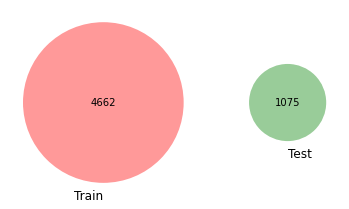

In [65]:
venn2(
    [clusters_in_train, clusters_in_test],
    ('Train', 'Test')
     );

In [66]:
meta_df.iloc[train_idxs].groupby(['label', 'complex_type']).size()

label  complex_type
0      hetero           442
       homo            3937
1      hetero          5535
       homo            7239
dtype: int64

In [67]:
meta_df.iloc[test_idxs].groupby(['label', 'complex_type']).size()

label  complex_type
0      hetero           109
       homo             986
1      hetero          1314
       homo            1876
dtype: int64

In [68]:
# meta_df.iloc[train_idxs].to_csv(
#     os.path.join(DATA_DIR, 'train_full.csv')
# )
# meta_df.iloc[test_idxs].to_csv(
#     os.path.join(DATA_DIR, 'test_full.csv')
# )

# drop rows with cropping error for the cropped version
meta_df_train_crop = meta_df.iloc[train_idxs].query('has_crop_error == False')
meta_df_train_crop['pdb_file'] = meta_df_train_crop['pdb_file']\
    .map(lambda x: x[:-3])

meta_df_test_crop = meta_df.iloc[test_idxs].query('has_crop_error == False')
meta_df_test_crop['pdb_file'] = meta_df_test_crop['pdb_file']\
    .map(lambda x: x[:-3])

meta_df_train_crop.to_csv(
    os.path.join(CROP_DATA_DIR, 'train_full.csv')
)
meta_df_test_crop.to_csv(
    os.path.join(CROP_DATA_DIR, 'test_full.csv')
)

In [69]:
# subsample to make smaller versions of the dataset
meta_df_train_sample = meta_df.iloc[train_idxs].sample(
    frac=0.1,
    random_state=42
)
meta_df_train_sample.to_csv(
    os.path.join(DATA_DIR, 'train_small.csv')
)

meta_df_test_sample = meta_df.iloc[test_idxs].sample(
    frac=0.1,
    random_state=42
)
meta_df_test_sample.to_csv(
    os.path.join(DATA_DIR, 'test_small.csv')
)
print(meta_df_train_sample.shape, meta_df_test_sample.shape)

# drop rows with cropping error for the cropped version
meta_df_train_sample = meta_df_train_sample.query('has_crop_error == False')
meta_df_train_sample['pdb_file'] = meta_df_train_sample['pdb_file']\
    .map(lambda x: x[:-3])

meta_df_test_sample = meta_df_test_sample.query('has_crop_error == False')
meta_df_test_sample['pdb_file'] = meta_df_test_sample['pdb_file']\
    .map(lambda x: x[:-3])

meta_df_train_sample.to_csv(
    os.path.join(CROP_DATA_DIR, 'train_small.csv')
)

meta_df_test_sample.to_csv(
    os.path.join(CROP_DATA_DIR, 'test_small.csv')
)

print(meta_df_train_sample.query('has_crop_error == False').shape,
      meta_df_test_sample.query('has_crop_error == False').shape,
     )

(1715, 13) (428, 13)
(1644, 13) (408, 13)


In [70]:
!ls {CROP_DATA_DIR}

non-physiol  test_full.csv   train_full.csv
physiol      test_small.csv  train_small.csv


## Read additional ProtCID cluster metadata (probably not informative for ML)

In [71]:
files = [
    'non-physiol/heteroNonPhysiolDimerList_unpPdbCF5_all.txt',
    'non-physiol/homoNonPhysiolDimerList_unpPdbCF5_all.txt',
    'physiol/heteroPhysiolDimerList_unpPdbCF5_all.txt',
    'physiol/homoPhysiolDimerList_unpPdbCF5_all.txt'
]

df = []
for file in files:
    temp_df = pd.read_csv(
        os.path.join(DATA_DIR, file),
        sep='\t'
    ).drop_duplicates()        

    df.append(temp_df)
    print(file, temp_df.shape)


non-physiol/heteroNonPhysiolDimerList_unpPdbCF5_all.txt (2362, 30)
non-physiol/homoNonPhysiolDimerList_unpPdbCF5_all.txt (27517, 30)
physiol/heteroPhysiolDimerList_unpPdbCF5_all.txt (109208, 30)
physiol/homoPhysiolDimerList_unpPdbCF5_all.txt (93568, 30)


In [72]:
df = pd.concat(df)
print(df.shape)

(232655, 30)


In [73]:
df.drop_duplicates().shape

(232655, 30)

In [74]:
df['id'] = df.apply(
    lambda row: '_'.join([
        row['UnpID'], row['PdbID'], str(row['InterfaceID'])
    ]),
    axis=1)
df['id'].nunique()

231415

In [77]:
df = df.loc[df['id'].isin(meta_df.index)]
print(df.shape, meta_df.shape)

(9139, 31) (21438, 12)


In [78]:
df.nunique()

UnpID                5396
PdbID                5028
InterfaceID           258
AsymID1               123
AsymID2               423
AuthChain1             86
AuthChain2            151
EntityID1             126
EntityID2             407
SymmetryOp1            88
SymmetryOp2           365
SurfaceArea          7715
SymmetryIndex        2056
ChainPfamArch1       2222
ChainPfamArch2       2246
InPDB                   2
InPISA                  2
DomainInterfaceID     233
PfamPair             2943
ClusterID             201
#CFs_unpClus          124
#Entries_unpClus      221
#CFs_unpPDB           137
#Entries_unpPdb       248
#CFs_clus             234
#Entries_clus         347
#CFs_rel              301
#Entries_rel          413
Resolution            807
Method                  6
id                   9075
dtype: int64

In [79]:
df['ClusterID'].value_counts()

 1      4914
-1      1624
 2      1075
 3       381
 4       183
        ... 
 153       1
 436       1
 506       1
 109       1
 44        1
Name: ClusterID, Length: 201, dtype: int64

In [80]:
df.groupby('id').size().sort_values(ascending=False)

id
RRP7_YEAST-UTP22_YEAST_4m5d_1          4
CALM3_HUMAN-KCNQ4_HUMAN_7byl_10        3
DPO3X_ECOLI-HOLA_ECOLI_1jr3_5          3
A0A1D8PP59_CANAL-QCR2_CANAL_7rja_37    3
PSA1_RAT-PSA3_RAT_6epc_77              3
                                      ..
FIMC_ECOLI-FIMD_ECOLI_7b0x_2           1
FIMA1_ECOLI_6y7s_11                    1
FIMA1_ECOLI_6s09_4                     1
FIMA1_ECOLI_6s09_11                    1
ZO1_HUMAN_2h3m_3                       1
Length: 9075, dtype: int64

In [81]:
df.loc[df['id'] == 'RRP7_YEAST-UTP22_YEAST_4m5d_1']

,UnpID,PdbID,InterfaceID,AsymID1,AsymID2,AuthChain1,AuthChain2,EntityID1,EntityID2,SymmetryOp1,SymmetryOp2,SurfaceArea,SymmetryIndex,ChainPfamArch1,ChainPfamArch2,InPDB,InPISA,DomainInterfaceID,PfamPair,ClusterID,#CFs_unpClus,#Entries_unpClus,#CFs_unpPDB,#Entries_unpPdb,#CFs_clus,#Entries_clus,#CFs_rel,#Entries_rel,Resolution,Method,id
133393,RRP7_YEAST-UTP22_YEAST,4m5d,1,A,A,1,1_555,B,B,2,1_555,3087.55,-1.0,(Nrap)_(Nrap_D2)_(Nrap_D3)_(Nrap_D4)_(Nrap_D5)...,(RRM_Rrp7)_(RRP7),1.0,0.0,4,(Nrap_D6)(RRP7),1,17,17,23,23,17,17,26,26,1.97,X-RAY DIFFRACTION,RRP7_YEAST-UTP22_YEAST_4m5d_1
133416,RRP7_YEAST-UTP22_YEAST,4m5d,1,A,A,1,1_555,B,B,2,1_555,3087.55,-1.0,(Nrap)_(Nrap_D2)_(Nrap_D3)_(Nrap_D4)_(Nrap_D5)...,(RRM_Rrp7)_(RRP7),1.0,0.0,2,(Nrap_D4)(RRP7),1,23,23,23,23,30,30,30,30,1.97,X-RAY DIFFRACTION,RRP7_YEAST-UTP22_YEAST_4m5d_1
133439,RRP7_YEAST-UTP22_YEAST,4m5d,1,A,A,1,1_555,B,B,2,1_555,3087.55,-1.0,(Nrap)_(Nrap_D2)_(Nrap_D3)_(Nrap_D4)_(Nrap_D5)...,(RRM_Rrp7)_(RRP7),1.0,0.0,1,(Nrap_D4)(RRM_Rrp7),1,23,23,23,23,26,26,29,29,1.97,X-RAY DIFFRACTION,RRP7_YEAST-UTP22_YEAST_4m5d_1
133462,RRP7_YEAST-UTP22_YEAST,4m5d,1,A,A,1,1_555,B,B,2,1_555,3087.55,-1.0,(Nrap)_(Nrap_D2)_(Nrap_D3)_(Nrap_D4)_(Nrap_D5)...,(RRM_Rrp7)_(RRP7),1.0,0.0,3,(Nrap_D6)(RRM_Rrp7),1,23,23,23,23,29,29,30,30,1.97,X-RAY DIFFRACTION,RRP7_YEAST-UTP22_YEAST_4m5d_1


In [70]:
# meta_df.loc['C4QZQ7_KOMPG-C4R4Y0_KOMPG_5x4z_1']

In [56]:
df['Resolution'].describe()

count    2362.000000
mean        3.480883
std         2.384415
min         0.000000
25%         2.500000
50%         3.040000
75%         3.700000
max        40.000000
Name: Resolution, dtype: float64

In [57]:
df.groupby(['UnpID', 'PdbID', 'InterfaceID']).size()

UnpID                      PdbID  InterfaceID
1A02_HUMAN-B2MG_HUMAN      3mrf   1              1
                           4l29   8              1
                                  35             1
                           6apn   1              1
1A68_HUMAN-B2MG_HUMAN      1tmc   2              1
                                                ..
W8TUC9_STAAU-W8TVK2_STAAU  7asp   3              1
XPO1_YEAST-YRB1_YEAST      5ysu   9              1
                           6lq9   9              1
XRCC5_HUMAN-XRCC6_HUMAN    1jey   10             1
                           6erg   7              1
Length: 2362, dtype: int64

## EDA for the 1st batch of ProtCID data

In [5]:
cluster_df = pd.read_csv(
    os.path.join(DATA_DIR, 'ChainHeteroClusterList_CF5.txt'),
    sep='\t',
    skiprows=11
)
print(cluster_df.shape)
cluster_df.head()

(1831, 10)


,ChainGroupID,ChainPfamArch,ClusterID,#PDBBAs,#PISABAs,#CFs/Cluster,#CFs/Group,#Entries/Cluster,#Entries/Group,MinSequenceIdentity
0,17,(C1-set);(MHC_I)_(C1-set),1.0,1063.0,990.0,518.0,519.0,1066.0,1150.0,8.00
1,17,(C1-set);(MHC_I)_(C1-set),2.0,0.0,3.0,41.0,519.0,98.0,1150.0,18.37
2,17,(C1-set);(MHC_I)_(C1-set),3.0,0.0,4.0,30.0,519.0,45.0,1150.0,22.68
3,17,(C1-set);(MHC_I)_(C1-set),4.0,0.0,0.0,28.0,519.0,69.0,1150.0,83.00
4,17,(C1-set);(MHC_I)_(C1-set),5.0,0.0,4.0,25.0,519.0,63.0,1150.0,18.56


In [6]:
cluster_df.nunique()

ChainGroupID           1460
ChainPfamArch          1456
ClusterID                51
#PDBBAs                 222
#PISABAs                127
#CFs/Cluster            185
#CFs/Group              191
#Entries/Cluster        221
#Entries/Group          231
MinSequenceIdentity     514
dtype: int64

In [7]:
cluster_df['ChainPfamArch1'] = cluster_df['ChainPfamArch']\
    .map(
        lambda x: x.split(';')[0] if not pd.isnull(x) else np.nan
    )
cluster_df['ChainPfamArch2'] = cluster_df['ChainPfamArch']\
    .map(
        lambda x: x.split(';')[1] if not pd.isnull(x) and ';' in x else np.nan
    )

print('Types of Pfam arch in clusters:')
cluster_df[['ChainPfamArch1', 'ChainPfamArch2']].nunique()

Types of Pfam arch in clusters:


ChainPfamArch1    633
ChainPfamArch2    620
dtype: int64

In [8]:
cluster_df['ChainPfamArch1'].value_counts().head(10)

(V-set)_(C1-set)                                                                        42
(C1-set)                                                                                27
(Actin)                                                                                 19
(Herpes_MCP)                                                                            17
(RNA_pol_Rpb1_1)_(RNA_pol_Rpb1_2)_(RNA_pol_Rpb1_3)_(RNA_pol_Rpb1_4)_(RNA_pol_Rpb1_5)    16
(JAB)_(MitMem_reg)                                                                      16
(L51_S25_CI-B8)                                                                         15
(GP120)                                                                                 15
(PsaA_PsaB)                                                                             15
(Complex1_49kDa)                                                                        15
Name: ChainPfamArch1, dtype: int64

In [9]:
cluster_df['ChainPfamArch2'].value_counts().head(10)

(V-set)_(C1-set)                                 55
(MHC_I)_(C1-set)                                 30
(Trypsin)                                        18
(Ribosomal_S5)_(Ribosomal_S5_C)                  18
(Ribosomal_S18)                                  17
(Proton_antipo_N)_(Proton_antipo_M)_(NADH5_C)    15
(PSII)                                           15
(Photo_RC)                                       14
(V-set)                                          14
(Ribosomal_L7Ae)                                 13
Name: ChainPfamArch2, dtype: int64

In [10]:
cluster_df['#Entries/Cluster'].describe()

count    1827.000000
mean       50.082649
std        93.085530
min         6.000000
25%        10.000000
50%        22.000000
75%        48.000000
max      1066.000000
Name: #Entries/Cluster, dtype: float64

In [11]:
cluster_df['#Entries/Group'].describe()

count    1827.000000
mean      150.368911
std       514.388269
min         6.000000
25%        15.000000
50%        35.000000
75%        75.500000
max      3983.000000
Name: #Entries/Group, dtype: float64

In [12]:
cluster_df['MinSequenceIdentity'].describe()

count    1827.000000
mean       32.939048
std        25.273081
min         0.100000
25%        11.760000
50%        27.000000
75%        49.500000
max        89.260000
Name: MinSequenceIdentity, dtype: float64

## Load positive interactions

In [17]:
!head -30 {DATA_DIR}/ChainHeteroInterfaceList_CF5.txt

#ChainGroupID: the group ID in integer
#ClusterID: the cluster ID in integer
#PdbID
#InterfaceID: the interface ID in integer
#UnpCode: the UniProt codes for two chains, delimited by ";". Watch out some missing UniProt codes from SIFTs or PDB itself or bugs in my codes :-).
#SurfaceArea: the buried surface area (BSA) of the interface. BSA = (SA(chain A) + SA(chain B) - SA(interface AB)) / 2. 
#InAsu: whether the interface exists in the asymmetric unit. 1: exists; 0: not exists
#InPdb: whether the interface exists in the PDB biological assembly
#InPisa: whether the interface exists in the PISA biological assembly
#ASU: the asymmetric unit in ABC format. e.g. homo-dimer: A2, heterodimer: AB, homo-tetramer: A4, hetero-tetramer: A2B2, A3B
#PDBBA: the PDB biological assembly in ABC format
#PDBBaID: the biological assembly value. Most of times, it is an integer, but it can be a string in PDB.
#PISABA: the PISA biological assembly in ABC format
#PisaBaID: the biological assembly number in int

In [14]:
interface_df = pd.read_csv(
    os.path.join(DATA_DIR, 'ChainHeteroInterfaceList_CF5.txt'),
    sep='\t',
    comment='#'
)
print(interface_df.shape)
interface_df.head()

(91501, 28)


/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (14,16,17,20,24) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,ChainGroupID,ClusterID,PdbID,InterfaceID,UnpCode,SurfaceArea,InAsu,InPdb,InPisa,ASU,PDBBA,PdbBaID,PISABA,PisaBaID,Resolution,Method,RfactorWork,RfactorFree,AsymChain1,AuthChain1,EntityID1,SymmetryString1,AsymChain2,AuthChain2,EntityID2,SymmetryString2,ChainPfamArch1,ChainPfamArch2
0,17,1,1a1m,1,B2MG_HUMAN;HLAB_HUMAN,1247.90,1,1,1,ABC,ABC,1,ABC,1,2.3,X-RAY DIFFRACTION,0.205,0.0,B,B,2,1_555,A,A,1,1_555,(C1-set),(MHC_I)_(C1-set)
1,17,1,1a1n,1,B2MG_HUMAN;HLAB_HUMAN,1244.10,1,1,1,ABC,ABC,1,ABC,1,2.0,X-RAY DIFFRACTION,0.203,0.0,B,B,2,1_555,A,A,1,1_555,(C1-set),(MHC_I)_(C1-set)
2,17,1,1a1o,1,B2MG_HUMAN;HLAB_HUMAN,1275.90,1,1,1,ABC,ABC,1,ABC,1,2.3,X-RAY DIFFRACTION,0.168,0.0,B,B,2,1_555,A,A,1,1_555,(C1-set),(MHC_I)_(C1-set)
3,17,1,1a6z,1,B2MG_HUMAN;HFE_HUMAN,1240.10,1,1,1,A2B2,AB,1,AB,1,2.6,X-RAY DIFFRACTION,0.233,0.277,B,B,2,1_555,A,A,1,1_555,(C1-set),(MHC_I)_(C1-set)
4,17,1,1a9b,1,B2MG_HUMAN;HLAB_HUMAN,1364.95,1,1,1,A2B2C2,ABC,1,ABC,1,3.2,X-RAY DIFFRACTION,0.251,0.305,B,B,2,1_555,A,A,1,1_555,(C1-set),(MHC_I)_(C1-set)


In [16]:
interface_df.nunique()

ChainGroupID        1456
ClusterID             51
PdbID              12852
InterfaceID          434
UnpCode            11307
SurfaceArea        33227
InAsu                  2
InPdb                  2
InPisa                 2
ASU                  725
PDBBA                653
PdbBaID                3
PISABA               297
PisaBaID               8
Resolution          2022
Method                 7
RfactorWork         4115
RfactorFree         4235
AsymChain1           229
AuthChain1          1179
EntityID1            181
SymmetryString1      158
AsymChain2           239
AuthChain2          1222
EntityID2            183
SymmetryString2      200
ChainPfamArch1       642
ChainPfamArch2       645
dtype: int64

In [18]:
interface_df['ClusterID'].value_counts()

1      79582
2       7221
3       2318
5        561
4        453
11       200
6        197
7        136
9         92
19        81
8         50
30        41
16        35
39        34
10        30
70        25
12        23
18        22
72        22
73        21
64        21
14        20
17        20
99        19
13        19
167       15
15        15
20        14
21        13
24        12
173       12
258       11
184       11
195       11
196       11
239       10
236       10
25        10
211       10
235       10
223        9
22         9
261        9
250        8
23         8
276        7
280        7
302        7
310        7
304        6
305        6
Name: ClusterID, dtype: int64

In [19]:
interface_df['Method'].value_counts()

ELECTRON MICROSCOPY         54374
X-RAY DIFFRACTION           37057
SOLUTION NMR                   49
-                              18
SOLUTION SCATTERING             1
ELECTRON CRYSTALLOGRAPHY        1
NEUTRON DIFFRACTION             1
Name: Method, dtype: int64

In [20]:
#ASU: the asymmetric unit in ABC format. 
# e.g. homo-dimer: A2, heterodimer: AB, homo-tetramer: A4, hetero-tetramer: A2B2, A3B
interface_df['ASU'].value_counts().head(10)

A2BCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqr                                                         5227
ABC                                                                                                   3403
AB                                                                                                    2401
A2B2C2D2E2F2G2H2I2J2K2L2M2N2O2P2Q2R2S2T2U2V2W2X2Y2Z2a2b2c2d2e2f2g2h2i2j2k2l2m2n2o2p2q2r2s2t2u2v2w2    2063
ABCD                                                                                                  1864
ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz                                                  1849
ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789ABCDEFGHIJKLMN                          1736
ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789ABCDEFGHIJKLMNOP                        1683
A2B2C2D2E2F2G2H2I2J2K2L2M2N2                                                                          1539
A2B2C2                               

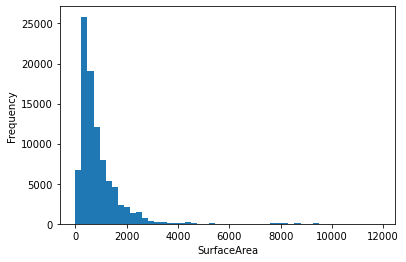

In [21]:
ax = interface_df['SurfaceArea'].plot(kind='hist', bins=50)
ax.set(xlabel='SurfaceArea');

## Examine PDB files in ProtCID

In [22]:
import sys
sys.path.append('ppi-model')

In [23]:
from ppi.data_utils import parse_pdb_structure, extract_coords

In [24]:
# from ppi.data_utils import SloppyStructureBuilder

In [25]:
from Bio.PDB import PDBParser

In [26]:
pdb_id = '6k15_41'

pdb_parser = PDBParser(
    QUIET=True,
    PERMISSIVE=True,
#     structure_builder=SloppyStructureBuilder(),
)

structure = pdb_parser.get_structure(
    pdb_id, 
    os.path.join(DATA_DIR, f'{pdb_id}.pdb')                 
)

In [27]:
recs = extract_coords(structure)
recs.keys()

dict_keys(['A', 'B'])

In [28]:
recs['A']['seq']

'AVFDLMTSPFTQEEVLIKEIDFLKNKLLDLQSL'

In [29]:
recs['B']['seq']

'PLNWVQGPAIFHMLTSPYTQDEIINHEMNFLKGRLLELQEIT'

In [30]:
import matplotlib

def plot_backbone(rec: dict, ax):
    '''
    3d plot for the backbone atoms from a chain.
    '''
    coords = np.asarray(rec['coords'])
    atoms = ["N", "CA", "C", "O"]
    for i, atom in enumerate(atoms):
        ax.scatter(coords[:, i, 0],
                   coords[:, i, 1],
                   coords[:, i, 2],
                   label='%s:%s' % (rec['name'], atom)
                  );

    # connect backbone atoms sequentially
    coords_stacked = coords.reshape(-1, 3)
    N_atoms = coords_stacked.shape[0]
    edge_pos = np.array([(coords_stacked[u], coords_stacked[u+1]) \
                         for u in range(N_atoms-1)])

    # Plot the edges
    for vizedge in edge_pos:
        ax.plot(*vizedge.T, color="tab:gray")

    return ax 

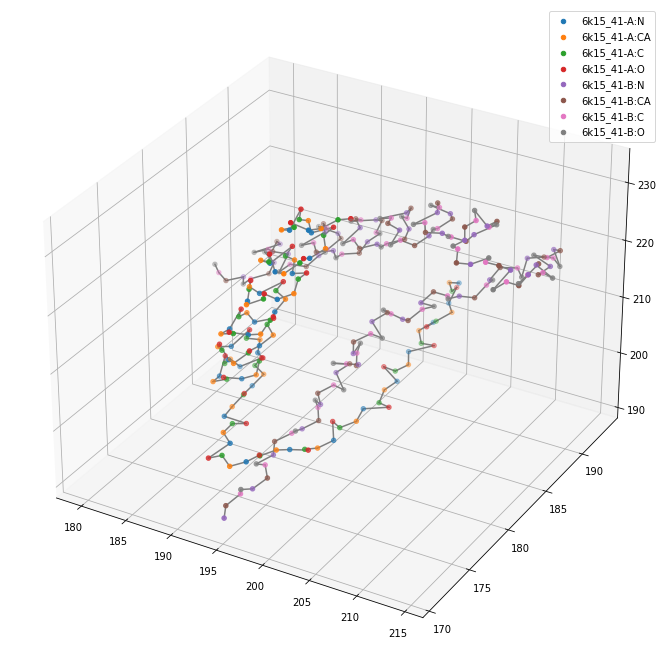

In [31]:
# Visualize 4 key atoms across amino acid residues in the pair of proteins
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

for chain_id in recs:
    ax = plot_backbone(recs[chain_id], ax)
    
ax.legend()

## Download PDB files

In [55]:
!wget https://www.rcsb.org/scripts/batch_download.sh

--2022-09-09 14:45:32--  https://www.rcsb.org/scripts/batch_download.sh
Resolving www.rcsb.org (www.rcsb.org)... 132.249.210.225
Connecting to www.rcsb.org (www.rcsb.org)|132.249.210.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2360 (2.3K) [application/x-sh]
Saving to: ‘batch_download.sh’

100%[======================================>] 2,360       --.-K/s   in 0s      

2022-09-09 14:45:32 (352 MB/s) - ‘batch_download.sh’ saved [2360/2360]



In [56]:
# write list_files
with open(os.path.join(DATA_DIR, 'list_files.txt'), 'w') as out:
    out.write(','.join(interface_df['PdbID'].unique()))

In [ ]:
!mkdir -p {DATA_DIR}/pdbs_from_rcsb
!chmod +x batch_download.sh
!sudo ./batch_download.sh -f {DATA_DIR}/list_files.txt -p -o {DATA_DIR}/pdbs_from_rcsb

Failed to download https://files.rcsb.org/download/5gpn.pdb.gz
Failed to download https://files.rcsb.org/download/5gup.pdb.gz
Failed to download https://files.rcsb.org/download/5xth.pdb.gz
Failed to download https://files.rcsb.org/download/5xti.pdb.gz
Failed to download https://files.rcsb.org/download/6q9d.pdb.gz
Failed to download https://files.rcsb.org/download/6qa9.pdb.gz
Failed to download https://files.rcsb.org/download/6qbx.pdb.gz
Failed to download https://files.rcsb.org/download/6qc2.pdb.gz
Failed to download https://files.rcsb.org/download/6qc3.pdb.gz
Failed to download https://files.rcsb.org/download/6qc4.pdb.gz
Failed to download https://files.rcsb.org/download/6qc5.pdb.gz
Failed to download https://files.rcsb.org/download/6qc6.pdb.gz
Failed to download https://files.rcsb.org/download/6qc7.pdb.gz
Failed to download https://files.rcsb.org/download/6qc8.pdb.gz
Failed to download https://files.rcsb.org/download/6qc9.pdb.gz
Failed to download https://files.rcsb.org/download/6qca

In [65]:
downloaded_pdb_files = os.listdir(
    os.path.join(DATA_DIR, 'pdbs_from_rcsb')
)
downloaded_pdb_files = [x.split('.')[0] for x in downloaded_pdb_files]
len(downloaded_pdb_files)

11710

In [66]:
downloaded_pdb_files[:10]

['6yw7',
 '7l0j',
 '4jm2',
 '3p73',
 '5u3p',
 '1afe',
 '1d3e',
 '6nzo',
 '4ucq',
 '1nyu']

In [67]:
missing_pdb_ids = set(interface_df['PdbID'].unique()) - set(downloaded_pdb_files)
len(missing_pdb_ids)

1142

In [68]:
# write list_files
with open(os.path.join(DATA_DIR, 'list_files_missing.txt'), 'w') as out:
    out.write(','.join(list(missing_pdb_ids)))

In [ ]:
!./batch_download.sh -f {DATA_DIR}/list_files_missing.txt -c -o {DATA_DIR}/pdbs_from_rcsb

## Download FASTA from RCSB

from https://ftp.wwpdb.org/pub/pdb/derived_data/pdb_seqres.txt.gz

In [85]:
from Bio import SeqIO
d_fasta = SeqIO.to_dict(
    SeqIO.parse(gunzip_to_ram(os.path.join(DATA_DIR, "pdb_seqres.txt.gz")), 
                "fasta")
)
len(d_fasta)

731589

In [87]:
list(d_fasta.items())[:10]

[('100d_A',
  SeqRecord(seq=Seq('CCGGCGCCGG'), id='100d_A', name='100d_A', description="100d_A mol:na length:10  DNA/RNA (5'-R(*CP*)-D(*CP*GP*GP*CP*GP*CP*CP*GP*)-R(*G)-3')", dbxrefs=[])),
 ('100d_B',
  SeqRecord(seq=Seq('CCGGCGCCGG'), id='100d_B', name='100d_B', description="100d_B mol:na length:10  DNA/RNA (5'-R(*CP*)-D(*CP*GP*GP*CP*GP*CP*CP*GP*)-R(*G)-3')", dbxrefs=[])),
 ('101d_A',
  SeqRecord(seq=Seq('CGCGAATTCGCG'), id='101d_A', name='101d_A', description="101d_A mol:na length:12  DNA (5'-D(*CP*GP*CP*GP*AP*AP*TP*TP*(CBR)P*GP*CP*G)-3')", dbxrefs=[])),
 ('101d_B',
  SeqRecord(seq=Seq('CGCGAATTCGCG'), id='101d_B', name='101d_B', description="101d_B mol:na length:12  DNA (5'-D(*CP*GP*CP*GP*AP*AP*TP*TP*(CBR)P*GP*CP*G)-3')", dbxrefs=[])),
 ('101m_A',
  SeqRecord(seq=Seq('MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRVKHLKTEA...YQG'), id='101m_A', name='101m_A', description='101m_A mol:protein length:154  MYOGLOBIN', dbxrefs=[])),
 ('102d_A',
  SeqRecord(seq=Seq('CGCAAATTTGCG'), id='102d

In [88]:
pdb_ids_in_protcid = set(interface_df['PdbID'].unique())
len(pdb_ids_in_protcid)

12852

In [92]:
interface_df.iloc[0]

ChainGroupID                          17
ClusterID                              1
PdbID                               1a1m
InterfaceID                            1
UnpCode            B2MG_HUMAN;HLAB_HUMAN
SurfaceArea                       1247.9
InAsu                                  1
InPdb                                  1
InPisa                                 1
ASU                                  ABC
PDBBA                                ABC
PdbBaID                                1
PISABA                               ABC
PisaBaID                               1
Resolution                           2.3
Method                 X-RAY DIFFRACTION
RfactorWork                        0.205
RfactorFree                          0.0
AsymChain1                             B
AuthChain1                             B
EntityID1                              2
SymmetryString1                    1_555
AsymChain2                             A
AuthChain2                             A
EntityID2       

In [118]:
# get obsolete PDB ids
import urllib
import urllib.request

obs_dict = {}

response = urllib.request.urlopen('ftp://ftp.wwpdb.org/pub/pdb/data/status/obsolete.dat')
for line in response:
    line = line.decode('utf-8')
    entry = line.split()
    if len(entry) == 4:
        obs_dict[entry[2].lower()] = entry[3].lower()
        
len(obs_dict)

4163

In [119]:
list(obs_dict.items())[:5]

[('116l', '216l'),
 ('125d', '1aw6'),
 ('14ps', '1qjb'),
 ('151c', '251c'),
 ('156b', '256b')]

In [120]:
row = interface_df.iloc[0]
pdb_chain_id = row['PdbID'] + '_' + row['AuthChain1']
str(d_fasta[pdb_chain_id].seq)

'IQRTPKIQVYSRHPAENGKSNFLNCYVSGFHPSDIEVDLLKNGERIEKVEHSDLSFSKDWSFYLLYYTEFTPTEKDEYACRVNHVTLSQPKIVKWDRDM'

In [121]:
# subset the fasta to chains in ProtCID
unmapped_pdb_chain_ids = []
d_fasta_protcid = {}
for _, row in interface_df.iterrows():
    pdb_id = obs_dict.get(row['PdbID'], row['PdbID'])
    
    if pd.isnull(row['AuthChain1']) or pd.isnull(row['AuthChain2']):
        continue
    pdb_chain_id1 = pdb_id + '_' + row['AuthChain1']
    pdb_chain_id2 = pdb_id + '_' + row['AuthChain2']
    
    try:
        d_fasta_protcid[pdb_chain_id1] = str(d_fasta[pdb_chain_id1].seq)
        d_fasta_protcid[pdb_chain_id2] = str(d_fasta[pdb_chain_id2].seq)
    except KeyError:
        unmapped_pdb_chain_ids.append(pdb_chain_id1)
        unmapped_pdb_chain_ids.append(pdb_chain_id2)
    
print('number of chains:', len(d_fasta_protcid))
print('number of unique sequences', len(set(d_fasta_protcid.values())))

number of chains: 95830
number of unique sequences 15779


In [122]:
len(unmapped_pdb_chain_ids)

42

In [123]:
# write a fasta file for all PDBBind protein sequences
with open(os.path.join(DATA_DIR, 'ProtCID_proteins.fasta'), 'w') as out:
    for pdb_chain_id, seq in d_fasta_protcid.items():
        out.write('>' + pdb_chain_id + '\n')
        out.write(seq + '\n')

In [108]:
# d_fasta['6nuy_1']

## Parse protein sequences from PDB files

In [77]:
from ppi.data_utils import gunzip_to_ram, three_to_one_standard

In [82]:
from Bio.PDB import MMCIFParser, PDBParser
from Bio.PDB.Polypeptide import three_to_one, is_aa

def get_pdb_structure(data_dir, pdb_id):
    # parse a protein structure from a PDB file
    pdb_parser = PDBParser(
        QUIET=True,
        PERMISSIVE=True,
    )
    pdb_file = os.path.join(data_dir, f'{pdb_id}.pdb.gz')
    structure = pdb_parser.get_structure(pdb_id, gunzip_to_ram(pdb_file))
    return structure

def get_cif_structure(data_dir, pdb_id):
    # parse a protein structure from a CIF file
    cif_parser = MMCIFParser(
        QUIET=True,
    )
    cif_file = os.path.join(data_dir, f'{pdb_id}.cif.gz')
    structure = cif_parser.get_structure(pdb_id, gunzip_to_ram(cif_file))
    return structure    

def get_chain_sequences(structure):
    result = {}
    ligands = []
    for chain in structure.get_chains():
        seq = "".join(
            [
                three_to_one_standard(res.get_resname())
                for res in chain.get_residues()
                if is_aa(res)
            ]
        )
        for res in chain.get_residues():
            if not is_aa(res) and res.id[0] != 'W':
                ligands.append(res.get_resname())
        result[chain.id] = seq
    return result, ligands

In [83]:
from tqdm import tqdm
all_seqs = []
all_ligands = []

pdb_dir = os.path.join(DATA_DIR, 'pdbs_from_rcsb')

for pdb_id in tqdm(interface_df['PdbID'].unique()):
    if os.path.isfile(os.path.join(pdb_dir, f'{pdb_id}.pdb.gz')):
        structure = get_pdb_structure(pdb_dir, pdb_id)
    else:
        structure = get_cif_structure(pdb_dir, pdb_id)
        
    seqs, ligands = get_chain_sequences(structure)
    all_seqs.append(seqs)
    all_ligands.append(ligands)

 18%|█▊        | 2321/12852 [1:25:11<6:26:32,  2.20s/it] 


PDBConstructionException: Blank altlocs in duplicate residue ILE (' ', 105, ' ')

In [ ]:
# write a fasta file for all PDBBind protein sequences
d_fasta = {} # pdb_id: seq
for pdb_id, d_seq in zip(interface_df['PdbID'].unique(), all_seqs):
    for chain, seq in d_seq.items():
        pdb_chain_id = pdb_id + '-' + chain
        d_fasta[pdb_chain_id] = seq
        
print('Number of protein chains:', len(d_fasta))

with open(os.path.join(DATA_DIR, 'ProtCID_proteins.fasta'), 'w') as out:
    for pdb_chain_id, seq in d_fasta.items():
        out.write('>' + pdb_chain_id + '\n')
        out.write(seq + '\n')